# Examples: Learning Capabilities

This notebook provides some examples of how to use Time Blender to learn model parameters from observable data.

In [1]:
from time_blender.random_events import *
from time_blender.deterministic_events import *
from time_blender.coordination_events import *

from time_blender.core import *
from time_blender.models import SimpleModels, ClassicModels, BankingModels, EconomicModels, EcologyModels
from time_blender.util import set_random_seed

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import urllib.request 
import zipfile
import copy
import os.path

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
matplotlib.rcParams['interactive'] = True
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]

For consistent results, we'll set a random seed as well.

In [3]:
set_random_seed(23)

Time period to consider.

In [4]:
start_date = pd.Timestamp.now() # or a fixed date, such as pd.Timestamp(2018, 1, 1)
end_date = start_date + pd.DateOffset(months=36)

print(f"Start date = {start_date}, end date = {end_date}")

Start date = 2020-10-30 11:30:11.538014, end date = 2023-10-30 11:30:11.538014


## Banking behavior

We'll try to learn some banking behavior here.

### Data

Let us use the user data from a Czech bank from a competition. Details can be found [here](https://sorry.vse.cz/~berka/challenge/pkdd1999/chall.htm), [here](https://webpages.uncc.edu/mirsad/itcs6265/group1/index.html) and [here](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions). We are interested in the evolution of each user's bank account.

Download data locally if we have not already done so.

In [5]:
if not os.path.isfile('../data/pkdd99_discovery_challenge_banking_dataset.zip'):
    urllib.request.urlretrieve('http://data.paulosalem.com/datasets/pkdd99_discovery_challenge_banking_dataset.zip', 
                               '../data/pkdd99_discovery_challenge_banking_dataset.zip')

In [6]:
with zipfile.ZipFile('../data/pkdd99_discovery_challenge_banking_dataset.zip') as myzip:
    with myzip.open('pkdd99_discovery_challenge_banking_dataset/data/trans.csv') as f:
        df_trans = pd.read_csv(f, parse_dates=['date'], infer_datetime_format=True)

df_trans.head()

/home/salem/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,1993-01-01,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,1993-01-01,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,1993-01-01,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,1993-01-01,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,1993-01-02,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


Let us now isolate each individual.



In [7]:
account_ids = df_trans['account_id'].unique()
users_transacions = {} # account id -> dataframe with transactions

In [8]:
for acc_id in account_ids:
    users_transacions[acc_id] = df_trans[df_trans['account_id'] == acc_id]

We need a function to plot the user's balance.



In [9]:
def user_balance_series(acc_id, users_transactions=users_transacions):
    df_u = users_transacions[acc_id]
    s_balance = df_u.groupby(df_u['date'])['balance'].mean()
    
    # fill the gaps, if any
    new_idx = pd.date_range(s_balance.index[0], s_balance.index[-1], freq=s_balance.index.freq)
    s_balance = s_balance.reindex(new_idx, method='ffill')
    
    return s_balance

In [10]:
def plot_user(acc_id, users_transactions=users_transacions, same_figure=False):
    s_balance = user_balance_series(acc_id, users_transactions)
    s_balance.plot(title=f'Acc. ID = {acc_id}, #events = {len(s_balance)}')
    if not same_figure:
        plt.show()

Let us pick a few random users to plot.



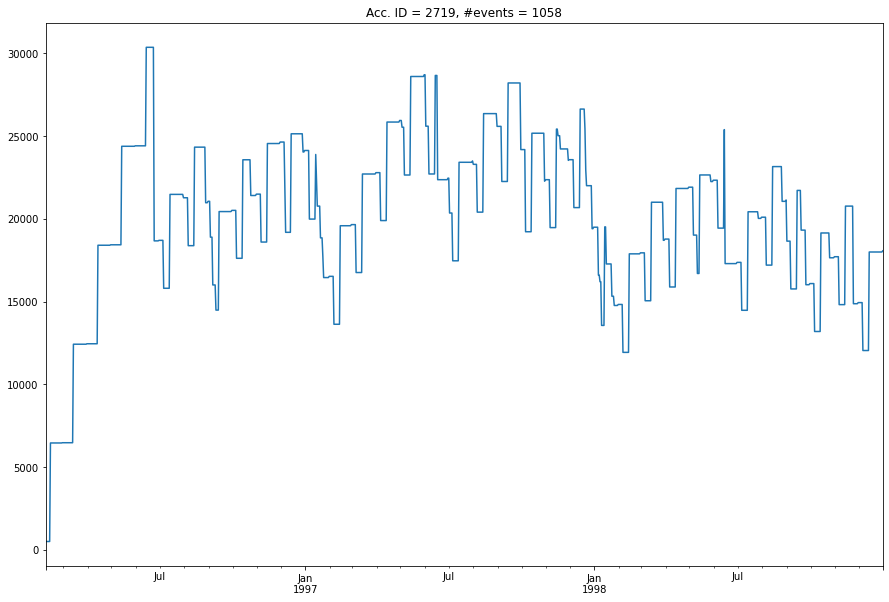

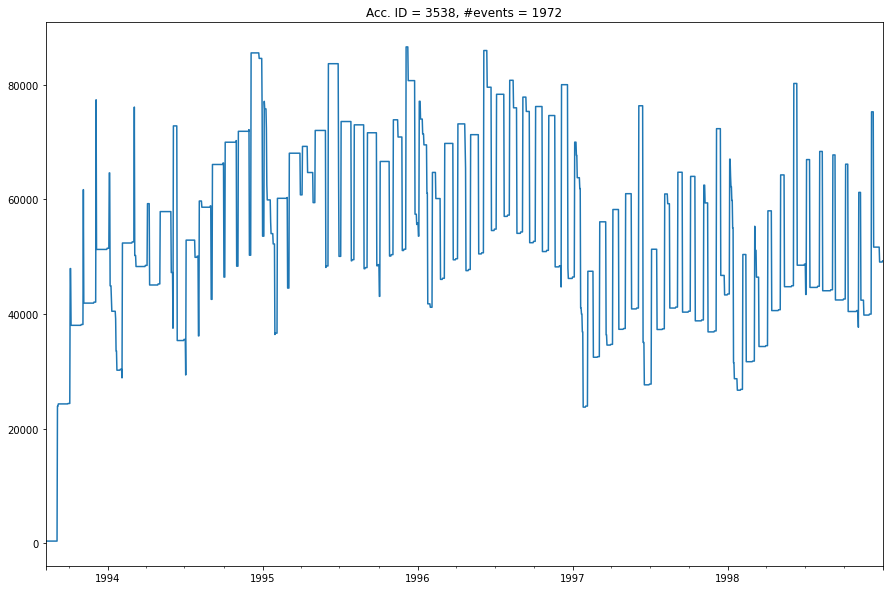

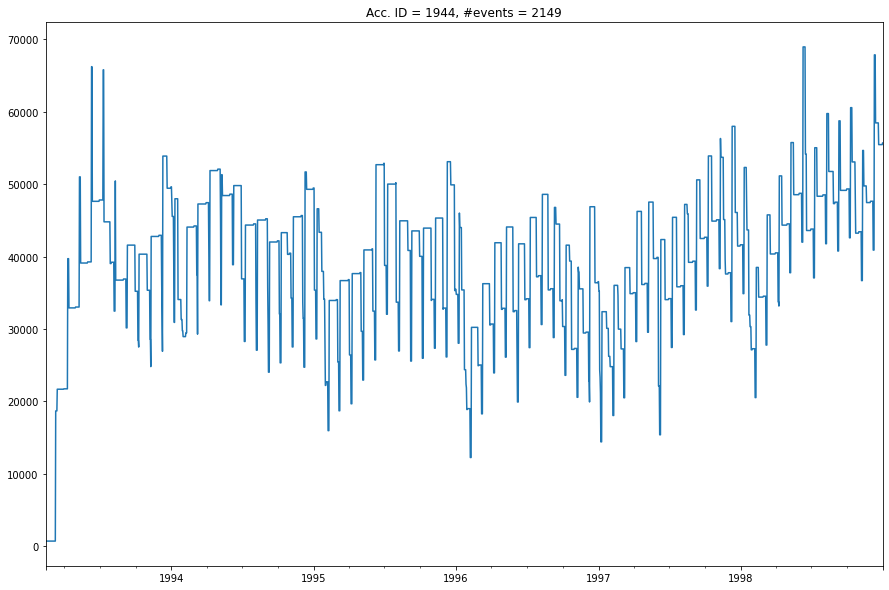

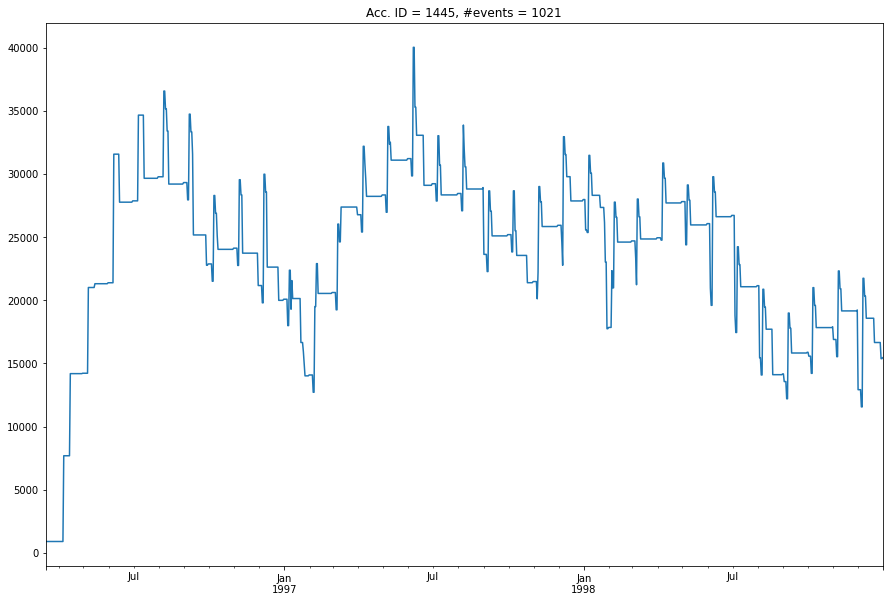

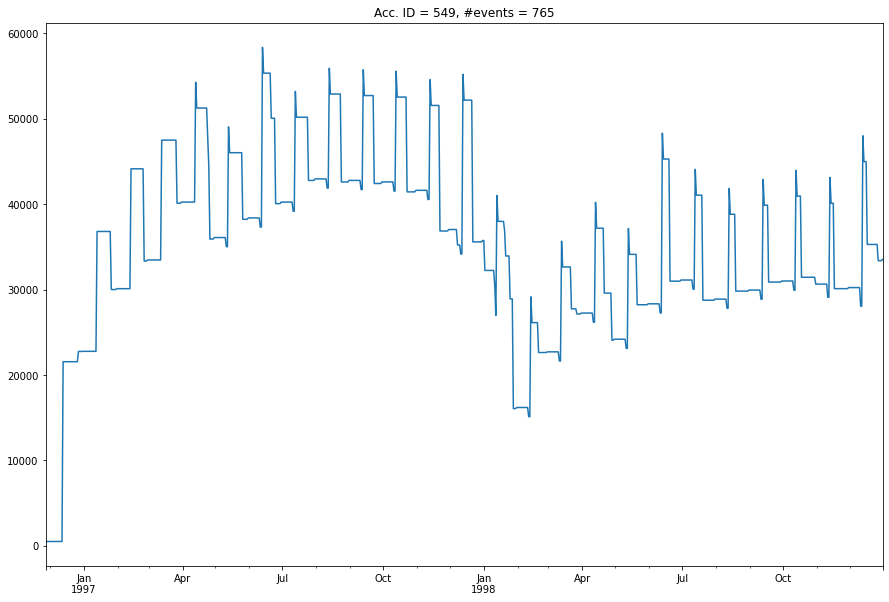

In [11]:
selected_account_ids = random.sample(list(account_ids), k=5)

for acc_id in selected_account_ids:
    plot_user(acc_id)

### TimeBlender Model

Now we can define TimeBlender models to learn from these data. First, let us format the data for proper use.

In [12]:
observed_traces = [user_balance_series(acc_id, users_transactions=users_transacions).values 
                   for acc_id in selected_account_ids]

We can now try different kinds of models.

#### Using ARIMA

How well can we model the desired behavior with classical ARIMA? Let's see.

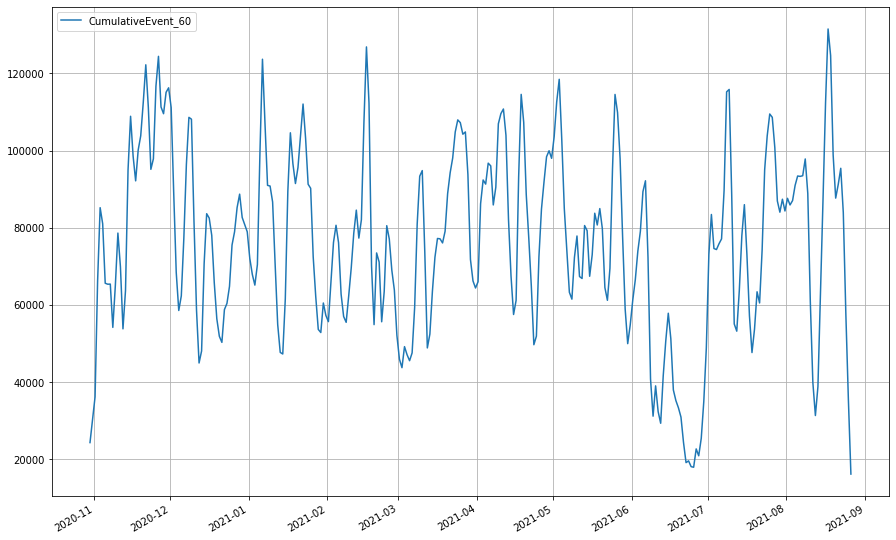

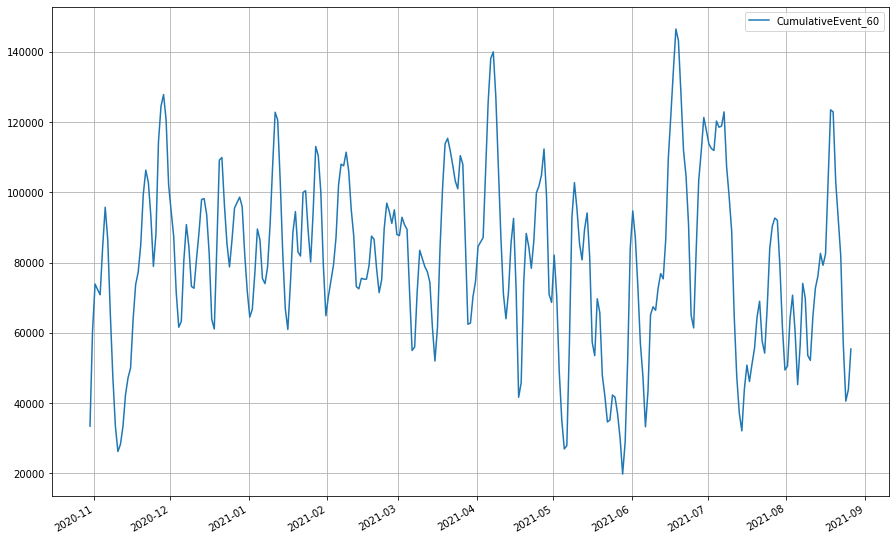

In [16]:
model_arima = ClassicModels.arima(3, 0, 
                                  constant=ConstantEvent(30000),
                                  ar_coefs=[-0.4, -0.3, 0.2], 
                                  error_mean=0, error_std=5000, 
                                  capture_parent_value=True)

generate_and_plot(model_arima, n=2, start_date=start_date, end_date=start_date + pd.DateOffset(days=300))

In [34]:
%%time
#model_arima.generalize_from_observations(observed_traces, 
#                                   max_optimization_evals=100, 
#                                   upper_bound=1, lower_bound=-1,
#                                   n_simulations=1,
#                                   error_strategy = 'best_trace')

model_arima.generalize_from_observations(observed_traces, 
                                   max_optimization_evals=2,
                                   n_simulations=3,
                                   error_strategy = 'best_trace',
                                   error_metric= 'mae',
                                   sample_proportion=0.1,
                                   verbose=True)

Considering 6 variables.
100%|██████████| 2/2 [00:01<00:00,  1.71trial/s, best loss: 3.6204878474627334e+302]
{'ConstantEvent_31': -39.04684890764736, 'ConstantEvent_35': 335.6288808822817, 'ConstantEvent_41': 1867.130849840553, 'ConstantEvent_47': 1.0611927890517876, 'ConstantEvent_54': 414.4389786167357, 'ConstantEvent_56': 11.778142874481162}
Best trial = {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 3.6204878474627334e+302, 'status': 'ok', 'min_error_trace_pos': 3}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'ConstantEvent_31': [1], 'ConstantEvent_35': [1], 'ConstantEvent_41': [1], 'ConstantEvent_47': [1], 'ConstantEvent_54': [1], 'ConstantEvent_56': [1]}, 'vals': {'ConstantEvent_31': [-39.04684890764736], 'ConstantEvent_35': [335.6288808822817], 'ConstantEvent_41': [1867.130849840553], 'ConstantEvent_47': [1.0611927890517876], 'ConstantEvent_54': [414.4389786167357], 'ConstantEvent_56': [11.778142874481162]}}, 'exp_key':

/home/salem/Documents/Software/time-blender/time_blender/core.py:342: RuntimeWarning: overflow encountered in double_scalars
  return LambdaEvent(lambda t, i, mem, sub_events: sub_events['a'].execute(t) * sub_events['b'].execute(t),


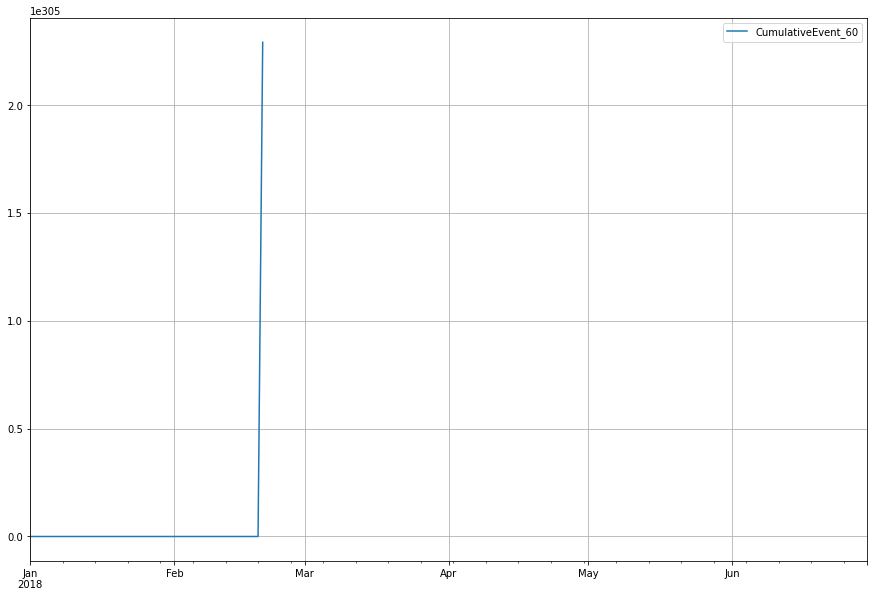

In [35]:
generate_and_plot(model_arima, n=1, start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2018, 6, 30), 
                  freq='D')

#### From Scratch

We'll now develop a custom model. The construction of the model has two important aspects:
  
  - the random generation should resemble the user cashflow behavior we saw above;
  - the model should incorporate as many "learning constraints" as possible, in order to speed-up the learning process.
  
So the approach combines human knowledge and algorithmic optimization.

We begin by defining the salary involved and the payday.

In [ ]:
##########################################
# Job parameters
##########################################
salary = ConstantEvent(20000, name='salary', 
                       require_lower_bound=0.0,
                       learning_normal_std = 5000)

payday = ConstantEvent(1, name='payday', allow_learning=False)

Next, we define the typical daily cashflow, mainly through the subtraction of various expenses from the salary.

In [ ]:
########################################
# Daily life
########################################


typical_daily_cashflow = SeasonalEvent(salary, day=payday, fill_with_previous=False)

# regular expenses
typical_daily_cashflow -= ClipEvent(NormalEvent(50, 10), 
                                    min_value=ConstantEvent(0.0, allow_learning=False))

# large expenses
typical_daily_cashflow -= ClipEvent(PoissonEvent(1)*ConstantEvent(1000), 
                                    min_value=ConstantEvent(0.0, allow_learning=False))

# emergencies
typical_daily_cashflow -= ClipEvent(BernoulliEvent(0.1) * NormalEvent(500, 100), 
                                    min_value=ConstantEvent(0.0, allow_learning=False))

# investments
typical_daily_cashflow -= ClipEvent(Choice([ConstantEvent(0),
                                            NormalEvent(500, 25),
                                            NormalEvent(1000, 50),
                                            NormalEvent(2000, 100)], fix_choice=True), 
                                    min_value=ConstantEvent(0.0, allow_learning=False))






By looking closely to the actual user behavior, we see that there is often a slight cyclic variation. To ensure this is represented, we explicitly add a `WaveEvent` to the model.

In [ ]:
# cyclic residual
typical_daily_cashflow -= WaveEvent(180, 200)

Payday is a special day, so we have to separate it from the other days. We do so through a custom `LambdaEvent`.

In [ ]:
non_payday_process = TemporarySwitch(typical_daily_cashflow,
                                     ConstantEvent(0.0, allow_learning=False),
                                     switch_duration=ConstantEvent(10, learning_normal_std=2))   

def aux_daily_cashflow(t, i, memory, sub_events):

    # ensures that on payday there is no temporary switch 
    if t.day == sub_events['payday'].execute(t):
        flow = sub_events['typical_daily_cashflow'].execute(t)
    else:
        flow = sub_events['non_payday_process'].execute(t)

    return sub_events['parent_value'].execute(t) + flow


parent_value = ParentValueEvent(default=0)

x = LambdaEvent(aux_daily_cashflow, sub_events={'payday': payday,
                                 'typical_daily_cashflow': typical_daily_cashflow,
                                 'non_payday_process': non_payday_process,
                                 'parent_value': parent_value})

Now we can wrap everything in resistances, so that the cashflow tends to stays within certain bounds.

In [ ]:
x = wrap_in_resistance(x, 
                       top_resistance_levels=[60000], 
                       bottom_resistance_levels=[-20000],
                       top_resistance_strength_event=ClipEvent(NormalEvent(0.1, 0.05), min_value=0.0),
                       bottom_resistance_strength_event=ClipEvent(NormalEvent(2, 1), min_value=0.0),
                       tolerance=20000,
                       top_resistance_probability=0.99, 
                       bottom_resistance_probability=0.99)

It is also possible to add invariants that help the search process and ensure certain properties. For example, let us enforce a minimum salary.

In [ ]:
##########################
# Invariants
##########################

invariant_1 = Invariant(lambda t, events: events['salary'].execute(t) >= 10000, 
                        events={'salary': salary})

x.add_invariant(invariant_1)

This gives us the final model.

In [36]:
salary_earner_model = x
#salary_earner_model = Replicated(x, 
#                                 duration_per_replication=NormalEvent(mean=360, std=90, allow_learning=False),
#                                 max_replication=3)


How many causal parameters we have in total?

In [37]:
len(salary_earner_model._causal_parameters_closure())

101

What does the cashflow component look like? Note that it shows clearly the incoming salary, as it should.

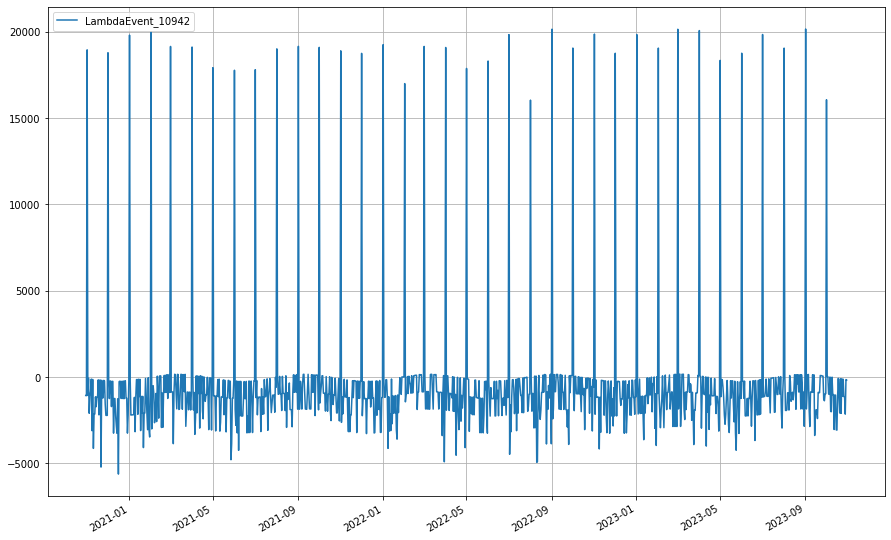

In [38]:
generate_and_plot(typical_daily_cashflow, n=1, start_date=start_date, end_date=end_date)

Finally we can generate time series from the model **before any learning takes place**. Note that it does ressemble the user behavior we saw earlier.

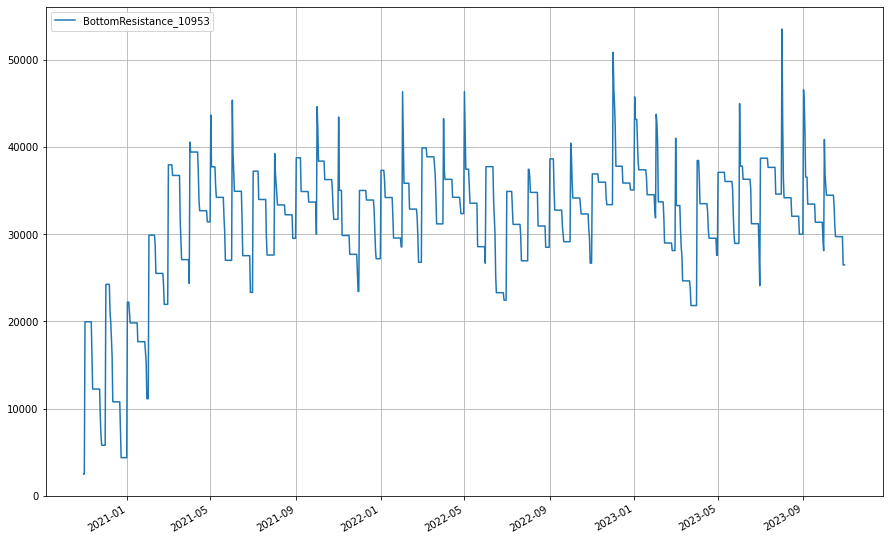

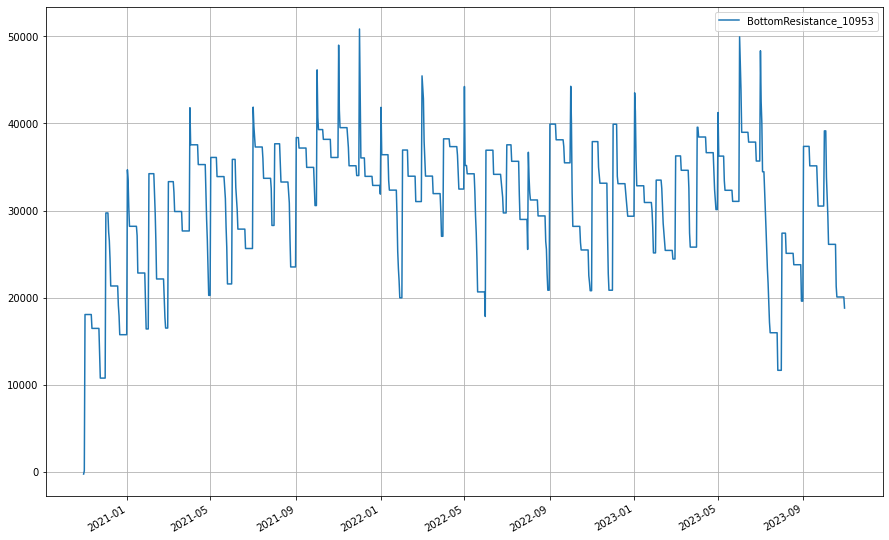

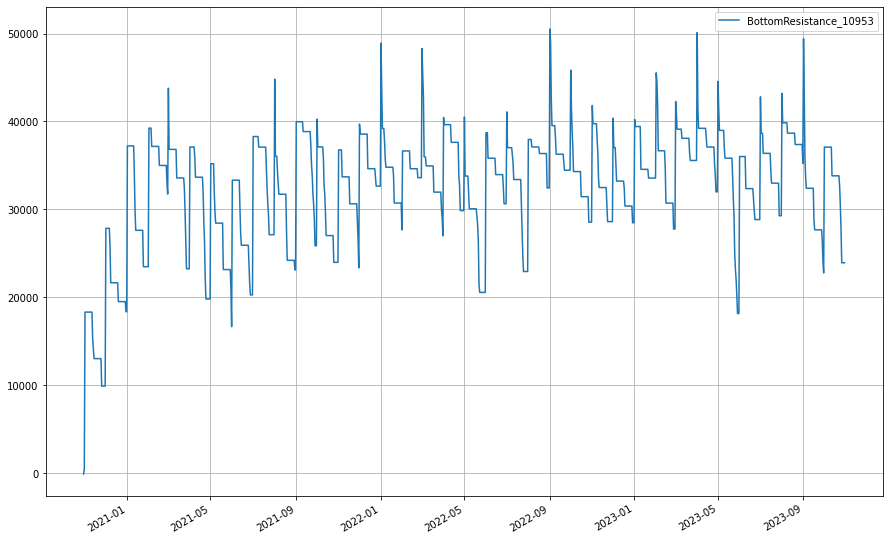

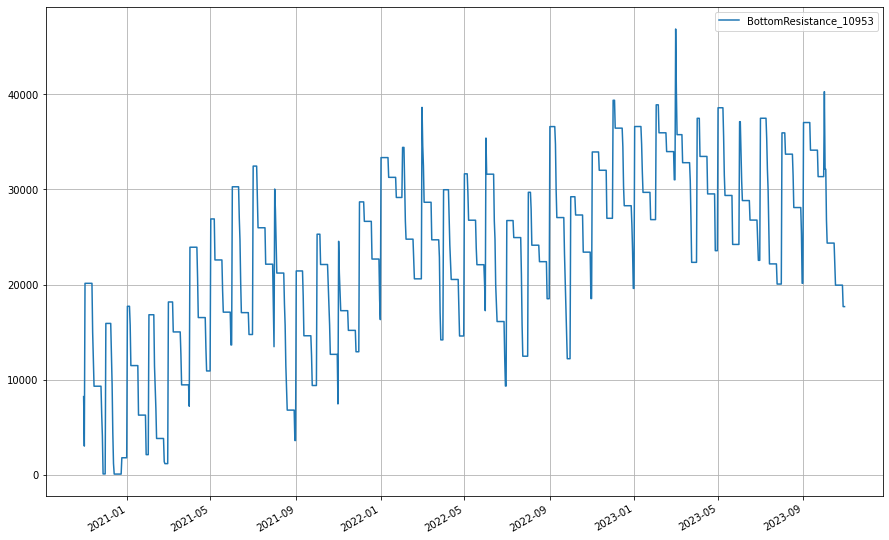

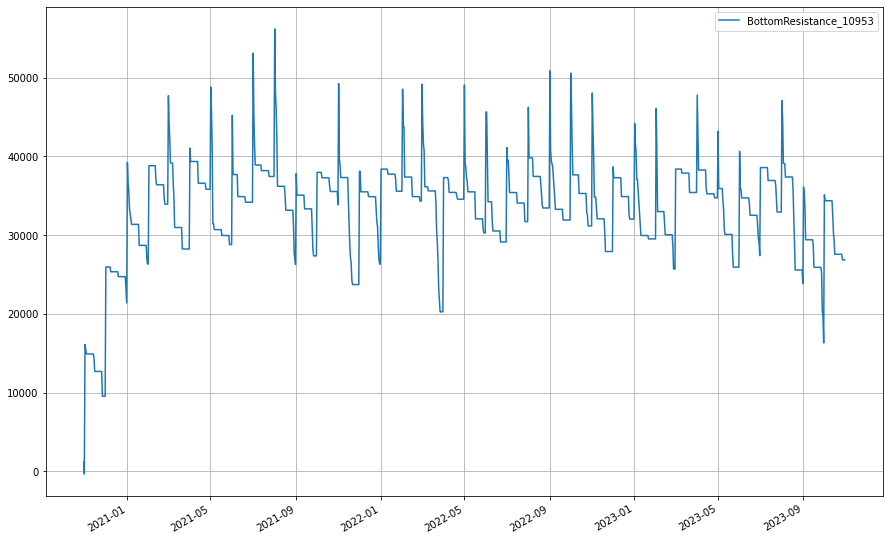

In [39]:
generate_and_plot(salary_earner_model, n=5, start_date=start_date, end_date=end_date)

But can we do better? Let's learn the model's parameters from the data.

In [57]:
%%time
salary_earner_model.generalize_from_observations(observed_traces, 
                                   max_optimization_evals=100,
                                   n_simulations=10,
                                   error_strategy = 'best_trace',
                                   error_metric= 'mae',
                                   generator = Generator(start_date=pd.Timestamp(2018, 1, 1), 
                                                         end_date=pd.Timestamp(2023, 1, 1)), 
                                   sample_proportion=1.0,
                                   verbose=True)

Considering 30 variables.
100%|██████████| 100/100 [19:18<00:00, 11.59s/trial, best loss: 8929.91721840543] 
{'BernoulliEvent_10926_p': 0.005016495328635715, 'ClipEvent_10949_min_value': -8.769107532913528, 'ClipEvent_10951_min_value': 1.2196188143384825, 'ConstantEvent_10921': 75.55605619248936, 'ConstantEvent_10932': 0.21377701617630213, 'ConstantEvent_10944': 16.020449469821106, 'None_resistance_probability': 0.6127473338910251, 'None_resistance_value_begin': -3.7297378858175527, 'None_resistance_value_end': -131308.75156122865, 'None_switch_probability': 0.8431787089387832, 'NormalEvent_10916_mean': 7316.353451667477, 'NormalEvent_10916_std': -1.2687753894852887, 'NormalEvent_10927_mean': -918.8183694130894, 'NormalEvent_10927_std': 0.04337485518690004, 'NormalEvent_10933_mean': -10.138012442875377, 'NormalEvent_10933_std': -229.61889314226653, 'NormalEvent_10934_mean': -833.4201649386132, 'NormalEvent_10934_std': 882.1513698793409, 'NormalEvent_10935_mean': -259885.8094979527, 'No

And here is the result.

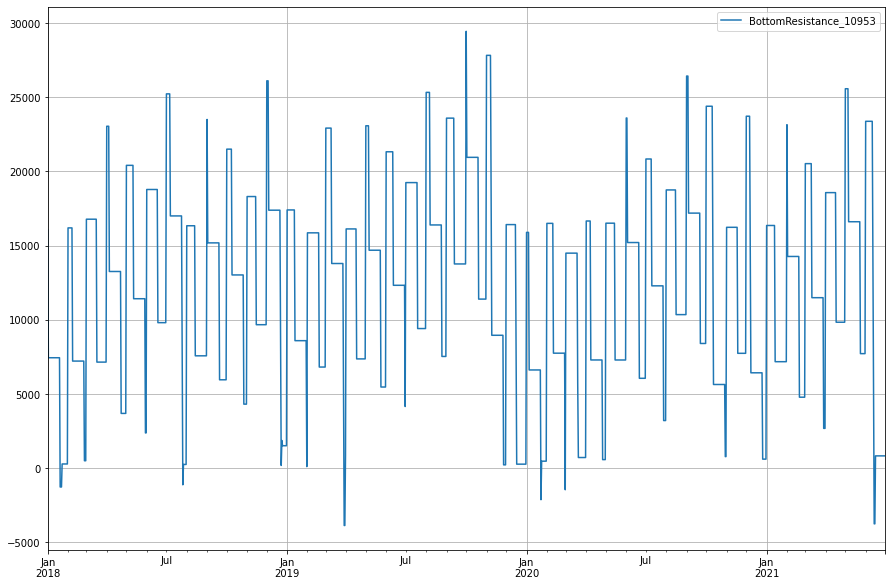

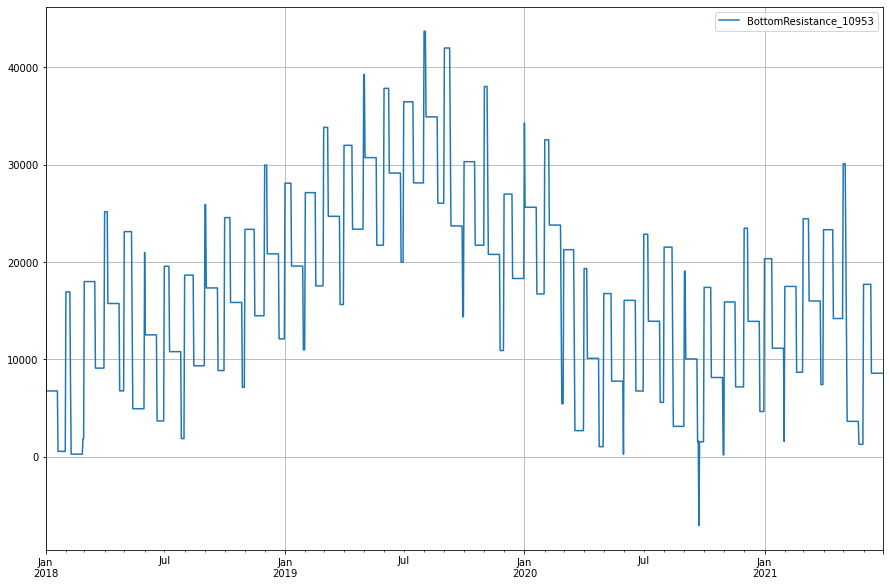

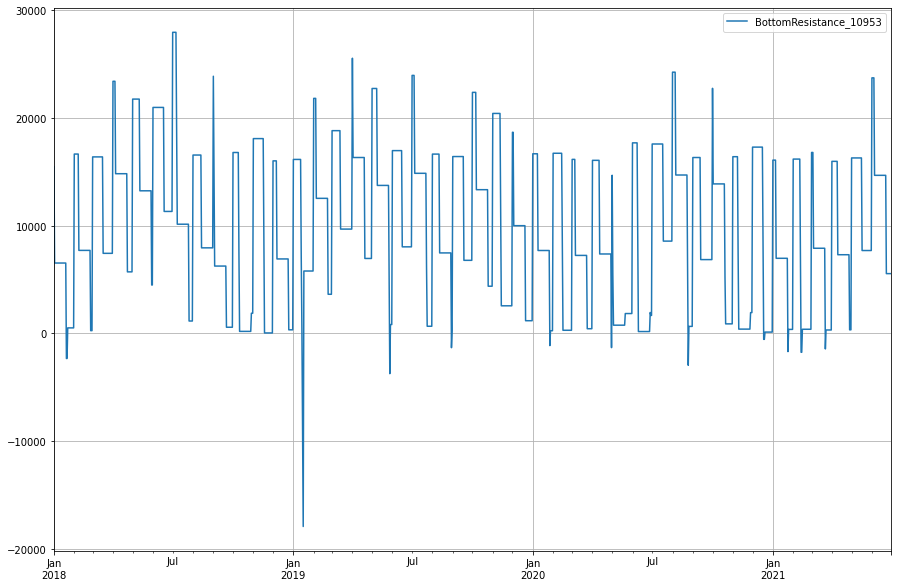

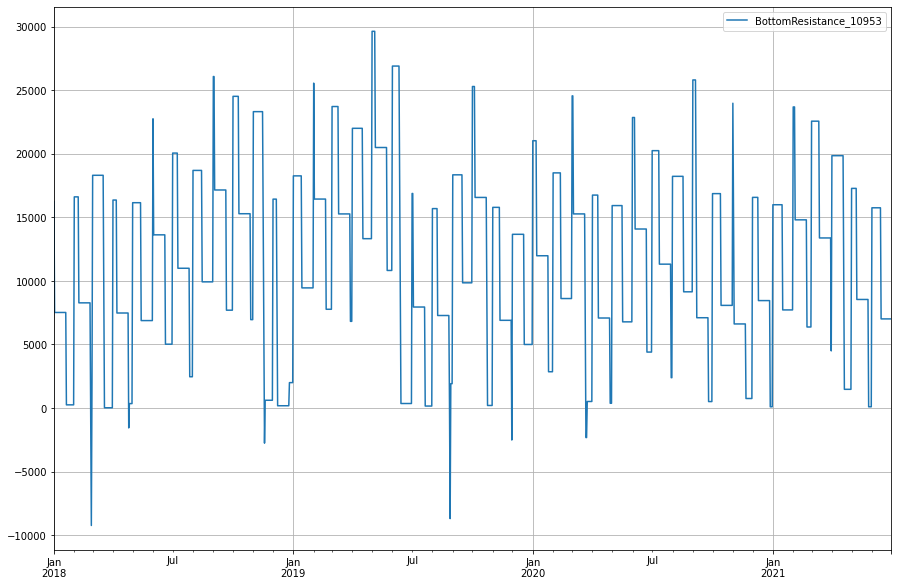

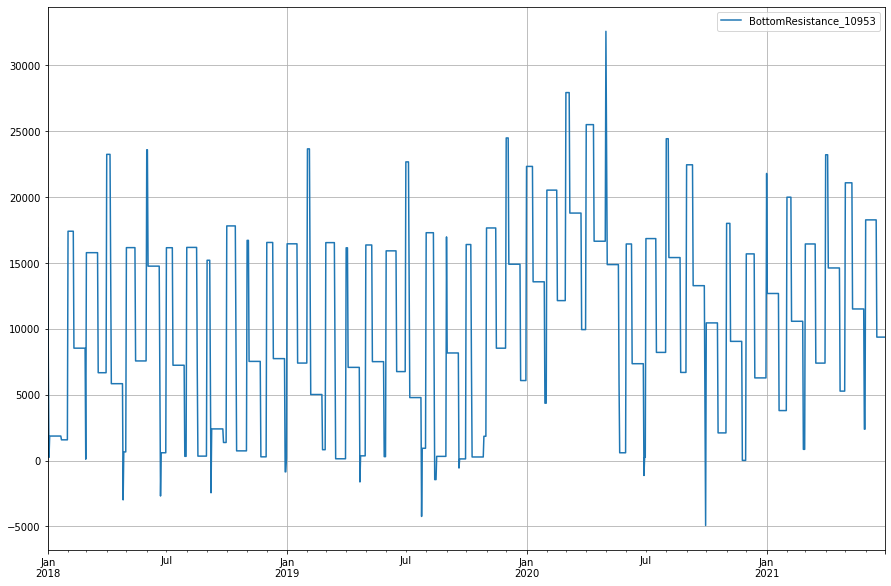

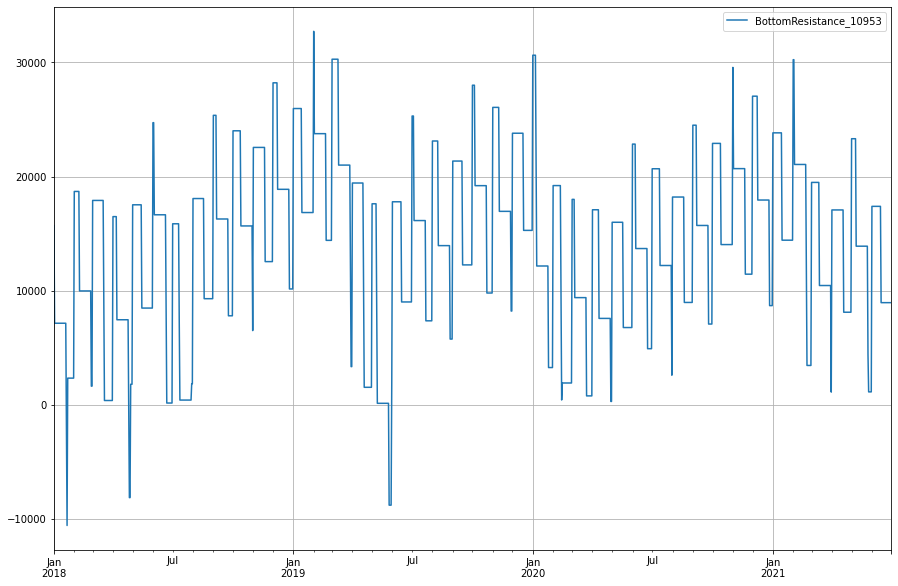

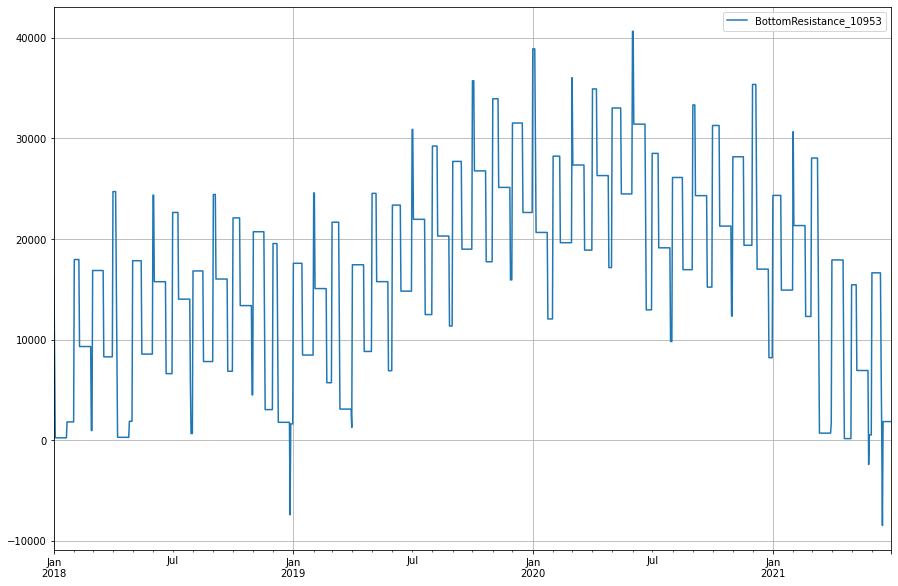

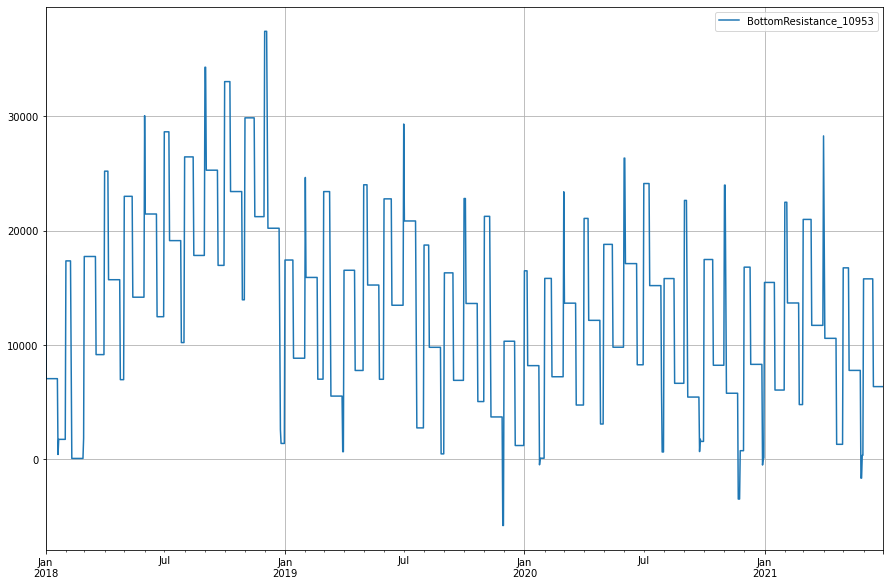

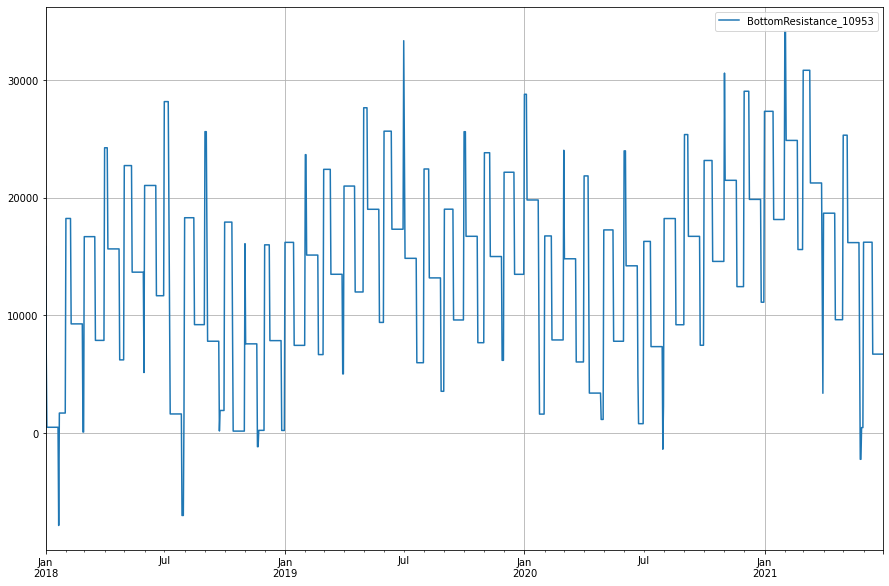

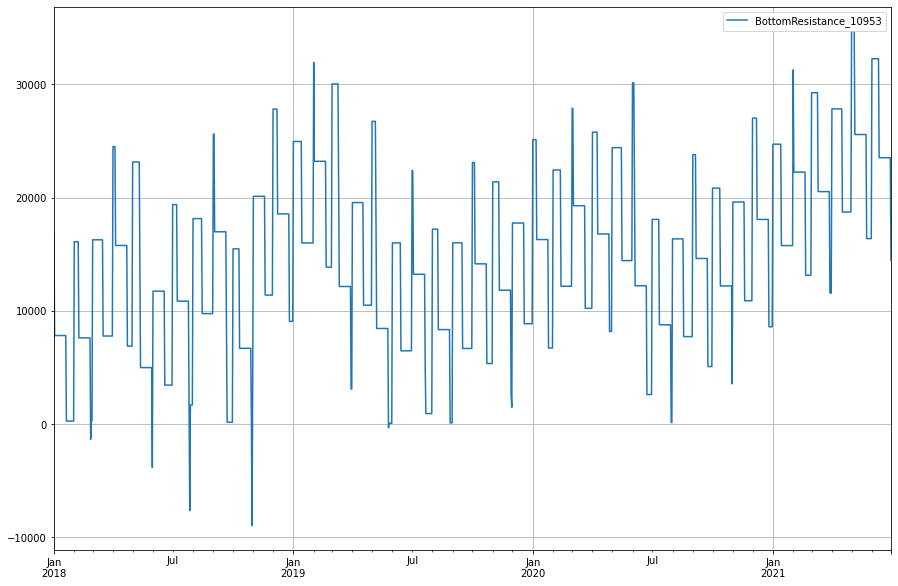

In [58]:
data = generate_and_plot(salary_earner_model, n=10, 
                         start_date=pd.Timestamp(2018, 1, 1), end_date=pd.Timestamp(2021, 6, 30), 
                         freq='D',
                         return_data=True)

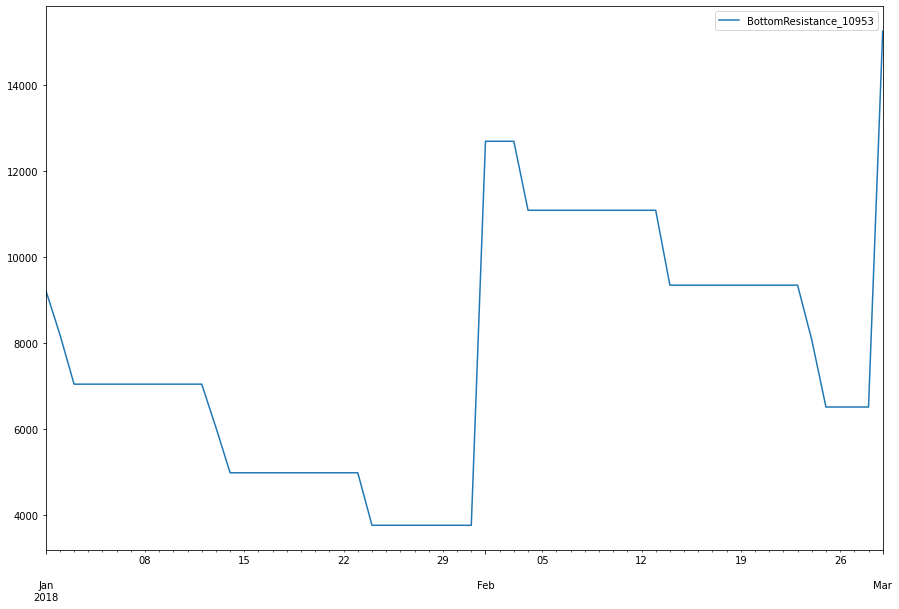

In [50]:
data[0].iloc[:60].plot()

In [51]:
data[0][:20]

,BottomResistance_10953
2018-01-01,9232.160464
2018-01-02,8197.980706
2018-01-03,7041.051796
2018-01-04,7041.051796
2018-01-05,7041.051796
2018-01-06,7041.051796
2018-01-07,7041.051796
2018-01-08,7041.051796
2018-01-09,7041.051796
2018-01-10,7041.051796
